In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
PATH = "data/dogscats/"
sz=224

In [6]:
torch.cuda.is_available()

True

In [7]:
os.listdir(PATH)

['.ipynb_checkpoints',
 'sample',
 'subm.csv',
 'sampleSubmission.csv',
 'sub',
 'valid',
 'models',
 'train',
 'tmp',
 'test1',
 'predictions.png']

In [8]:
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [9]:
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.11341.jpg',
 'cat.3869.jpg',
 'cat.5089.jpg',
 'cat.7380.jpg',
 'cat.11409.jpg']

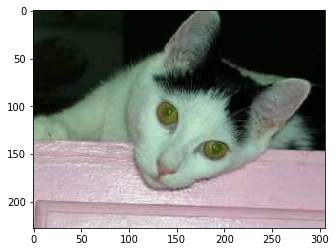

In [10]:
img = plt.imread(f'{PATH}valid/cats/{files[2]}')
plt.imshow(img);

In [ ]:
img.shape

In [ ]:
img[:4,:4]

In [ ]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

In [ ]:
log_preds = learn.predict()
log_preds.shape

In [ ]:
data.classes

In [ ]:
log_preds[:10]

In [ ]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [ ]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [ ]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [ ]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [ ]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [ ]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [ ]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [ ]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

In [ ]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

In [ ]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [ ]:
lrf=learn.lr_find()

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.sched.plot()

In [ ]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [ ]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [ ]:
ims = np.stack([get_augs() for i in range(6)])

In [ ]:
plots(ims, rows=2)

In [ ]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [ ]:
learn.fit(0.01, 1)

In [ ]:
learn.fit(0.01, 3, cycle_len=1)

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.save('224_lastlayer')

In [ ]:
learn.load('224_lastlayer')

In [ ]:
learn.unfreeze()

In [ ]:
lr=np.array([0.0001,0.001,0.01])

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.save('224_all')

In [ ]:
learn.load('224_all')

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [ ]:
accuracy_np(probs, y)

In [ ]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

In [ ]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

In [ ]:
### quick Dogs vs cats

In [7]:
sz = 224; bs = 64

In [ ]:
tfms = tfms_from_model(resnet50, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms= tfms, bs=bs, test_name='test1')
learn = ConvLearner.pretrained(resnet50, data )
% time learn.fit( 1e-2, 1, cycle_len=1)

# only one epoch

In [12]:
tfms = tfms_from_model(resnet50, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms= tfms, bs=bs, test_name='test1')
learn = ConvLearner.pretrained(resnet50, data )
% time learn.fit( 1e-2, 3, cycle_len=1)

# deeper model like resnet 50 

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.046501   0.029117   0.987305  
    1      0.050904   0.026056   0.989746                     
    2      0.032081   0.025344   0.989258                     

CPU times: user 13min 7s, sys: 1min 57s, total: 15min 4s
Wall time: 5min 29s


[0.025344076, 0.9892578125]

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [14]:
%time learn.fit([1e-5, 1e-4,1e-2], 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.0237     0.023561   0.992188  

CPU times: user 6min 10s, sys: 1min 23s, total: 7min 34s
Wall time: 4min 27s


[0.023561468, 0.9921875]

In [15]:
log_preds,y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds),0)

In [16]:
accuracy_np(probs, y)

0.50024

In [17]:
log_preds = learn.predict(is_test=True)

In [18]:
log_preds.shape

(12500, 2)

In [19]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

In [ ]:
max_preds = np.argmax(log_preds, 1)
class_preds = [data.classes[index_pred] for index_pred in max_preds]
fnames_nopath = [fname[5:] for fname in data.test_ds.fnames]
fname_preds = list(zip(fnames_nopath, class_preds))
df = pd.DataFrame(fname_preds)
df.columns = ["id", "label"]
df.to_csv(f'{PATH}subm.csv', index=False)

In [28]:
df = pd.DataFrame(probs)
df.head()

,0
0,0.992665
1,0.000026
2,0.974926
3,0.999996
4,0.999995


In [29]:
df.head()
df.insert(0,'id', [o[5:-4] for o in data.test_ds.fnames])
SUBM = f'{PATH}sub/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm.csv',index=False)

In [ ]:
fn = data.val_ds.fnames[1000]

In [ ]:
fn

In [ ]:
Image.open('data/dogscats/'+fn)

In [ ]:
trn_tfms, val_tfms = tfms_from_model(resnet50,sz)

In [ ]:
im = val_tfms(open_image('data/dogscats/'+fn))
preds = learn.predict_array(im[None])
np.argmax(preds)# 0 is cat # 1 is dog

In [ ]:
gn = data.val_ds.fnames[2]

In [ ]:
gn

In [ ]:
Image.open('data/dogscats/'+gn)

In [ ]:
im = val_tfms(open_image('data/dogscats/'+gn))
preds = learn.predict_array(im[None])
np.argmax(preds)# 0 is cat # 1 is dog

In [ ]:
mypreds = learn.predict(is_test=True)
mypreds[:4]